# Phase 4 Final Project: Classifying X-Rays for Pneumonia

## Overview
A chest x-ray is an important test for making a diagnosis of pneumonia. Chest x-rays can reveal areas of opacity (seen as white) which represent consolidation. Pneumonia is not always seen on x-rays, either because the disease is only in its initial stages, or because it involves a part of the lung not easily seen by x-ray.


Each year, pneumonia affects about 450 million people globally (7% of the population) and results in about 4 million deaths. With the introduction of antibiotics and vaccines in the 20th century, survival has greatly improved. Nevertheless, pneumonia remains a leading cause of death in developing countries, and also among the very old, the very young, and the chronically ill.


Chest x-rays are a crucial tool in the diagnosis process to assess pneumonia origin, severity, and treatment options. We will be building a neural network to classify x-ray images as normal or having pneumonia. A classification model with strong accuracy can aid medical professionals in making an accurate diagnosis as well as save them time and resources. 

# Import Necessary Libraries and Data

In [1]:
# Import libraries

import os, random, shutil
import cv2
import numpy as np
import pandas as pd
from pathlib import Path


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import layers
from keras import Model
from keras.regularizers import l2

In [2]:
# Read directory in

xray_dir = '/Users/Ozymandias/FlatironDSM/Phase4Project/dsc-phase-4-project/chest_xray/'

In [3]:
# Split directory by folder

train_dir = '{}train'.format(xray_dir)
val_dir = '{}val'.format(xray_dir)
test_dir = '{}test'.format(xray_dir)

# EDA

In [4]:
# Define a function to extract images into a folder and join each image to a label

labels = ['NORMAL', 'PNEUMONIA']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
# Pass directories through function 

train = get_data(train_dir)
test = get_data(test_dir)

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

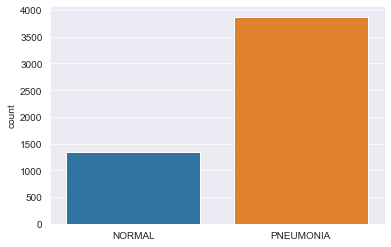

In [6]:
# Separate and plot training images by labels

l = []
for i in train:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)

/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

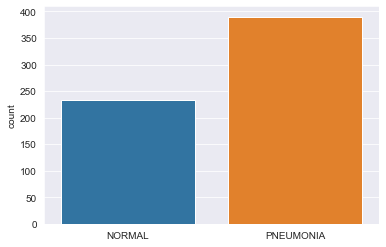

In [7]:
# Separate and plot testing images by labels

l = []
for i in test:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)

## Class Imbalance 
The training and test data are both quite imbalanced which can lead to over-fitting. We can attempt to correct this by using larger batch sizes in an effort to present proportional outcome distribution to the model during training. If the model drastically underperforms with default parameters, we will look into tuning the weights and bias. 

Text(0.5, 1.0, 'PNEUMONIA')

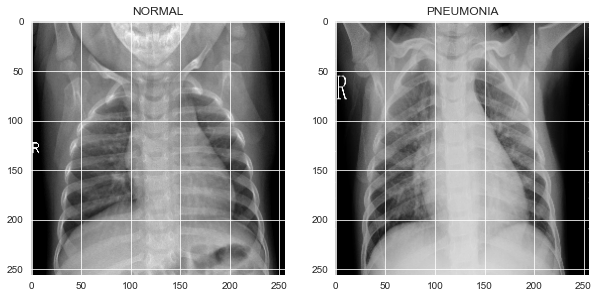

In [8]:
# Plot an example of each label for visual comparison

f = plt.figure(figsize = (10,10))
a1 = f.add_subplot(1,2,1)
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

a2 = f.add_subplot(1, 2, 2)
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

## Reviewing X-Rays
To the laymans eye there is very little difference in the examples above.  A trained medical professional can detect small differences and details that a layman isn't able to, but at the cost of many years of education and training. A model able to identify pneumonia with the same or improved accuracy as a medical professional is much more resource efficient. 

# Preprocessing

## Image Normalization & Augmentation

The pixel values in the colored downloaded images would be very high if left in the RGB format so we will scale and normalize each image using "rescale" in order to keep the image matrix sizes computable. 

Data Augmentation is a technique that increases the diversity of your training set by applying transformations to the image examples randomly such as rotation, zooming, shifting, shearing, and flipping around either axis. This diversification is useful in preventing overfitting on smaller datasets with lower numbers of examples. 

In [57]:
# Use Keras ImageDataGenerator to augment input data

#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, zoom_range=0.2, width_shift_range=0.1,
                                  #height_shift_range=0.1)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         horizontal_flip=True, vertical_flip=True)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        #batch_size=32,
        class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                        target_size=(150, 150), 
                                                        #batch_size=16, 
                                                        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                        target_size=(150, 150), 
                                                        #batch_size=32, 
                                                        class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Class Distributions
The dataset is comprised of three directories; train, validate, and test. The validate directory only has 16 images
in it which I hypothesize will lead to an unstable model that is over-fit. I will fit a base model using the
validate files and will then train additional models using a validation set partitioned from the train set and compare the outcomes. 

# Modeling

## Model Architecture
Convolutional neural network architecture uses a series of convolved and pooled layers to extract features from and reduce dimensionality of images. Convolutional layers move a filter around the original image detecting small local patterns in early layers and then larger more complex features in later layers. Pooling layers downsample the previous convoluted layer to manage dimensionality and produce viable training times. Lastly a fully connected dense layer is added to learn a final decision function based on the pooled and convolved transformed inputs.

## Model Parameters
There are several activation functions, loss functions, algorithm optimizers, and evaluation metrics available for use in neural networks. I will be using 'relu' "rectified linear unit" due to its popularity and consistency and a sigmoid function due to the models binary outcome as activation functions. I'll also be using the 'adam' "adaptive moment estimation" optimizer because due to being recommended by many research articles. Finally I'll be using binary cross entropy as a loss function and accuracy as an evaluation metric both due to have two possible class outcomes. 

## Base Model

In [58]:
# Instantiate a convolution neural network using convolutional layers, maxpooling layers, a flattened layer, 
# and dropout

base_model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [59]:
# Compile the model using the adaptive moment estimation (Adam) convergence algorithm, binary crossentropy as a loss
# metric as there are only two possible outcomes, and accuracy as the evaluation metric. 

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [50]:
# Check a summary of the model layers and their parameter counts

#basemodel.summary()

In [60]:
# Fit the baseline model using the training and validation data generators 

base_model_history = base_model.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1)

Epoch 1/10
163/163 [==============================] - 248s 2s/step - loss: 0.5398 - acc: 0.7425 - val_loss: 0.6532 - val_acc: 0.5000
Epoch 2/10
163/163 [==============================] - 211s 1s/step - loss: 0.4742 - acc: 0.7527 - val_loss: 0.6647 - val_acc: 0.5625
Epoch 3/10
163/163 [==============================] - 211s 1s/step - loss: 0.4476 - acc: 0.7697 - val_loss: 0.5136 - val_acc: 0.6250
Epoch 4/10
163/163 [==============================] - 226s 1s/step - loss: 0.4295 - acc: 0.7878 - val_loss: 0.6888 - val_acc: 0.6875
Epoch 5/10
163/163 [==============================] - 228s 1s/step - loss: 0.4037 - acc: 0.8073 - val_loss: 0.8191 - val_acc: 0.5625
Epoch 6/10
163/163 [==============================] - 213s 1s/step - loss: 0.3534 - acc: 0.8428 - val_loss: 0.4116 - val_acc: 0.8125
Epoch 7/10
163/163 [==============================] - 209s 1s/step - loss: 0.3116 - acc: 0.8673 - val_loss: 0.5682 - val_acc: 0.7500
Epoch 8/10
163/163 [==============================] - 208s 1s/step - 

In [12]:
# Define a function to plot model accuracy and loss against epochs 

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

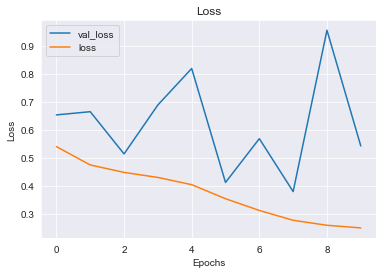

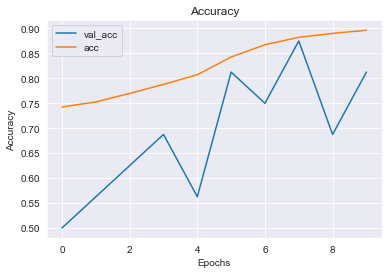

In [62]:
# Call plot function

visualize_training_results(base_model_history)

### Evaluate Base Model 
The base model scored 35.96% loss and 84.46% accuracy. I ran the model using a 256 image size value as well as a 150 image size value and the smaller image had the better performance. There are many data augmentation argument values as well as model parameters that we will explore once comparing different train test split outcomes.  

In [63]:
# Evaluate accuracy and loss of model against test data

print("Loss of the model is - " , base_model.evaluate(test_generator)[0]*100 , "%")
print("Accuracy of the model is - " , base_model.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 11s 520ms/step - loss: 0.3597 - acc: 0.8446
Loss of the model is -  35.96851825714111 %
20/20 [==============================] - 11s 501ms/step - loss: 0.3597 - acc: 0.8446
Accuracy of the model is -  84.45512652397156 %


In [ ]:
# Base Model History

#1 - ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, vertical_flip=True)
        # Input(256,256) Loss: 40.25% Accuracy: 81.57%
        
#2 - ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, vertical_flip=True)
        # Input(150,150) Loss: 35.97% Accuracy: 84.46%

## Modeling w/ Validation Split
Keras ImageDataGenerator has a built in argument to generate a validation set out of the training set data called 'validation_split'. Due to the included validation set only having 16 images we will disregard it from this point and partition 15% of the training data as a validation dataset in an effort to train a more accurate model.

In [15]:
train_split_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                                      horizontal_flip=True, vertical_flip=True, validation_split=0.15)

train_split_dataset = train_split_datagen.flow_from_directory(train_dir, shuffle=True, target_size=(150, 150), 
                                                 subset="training", class_mode='binary')


validation_split_dataset = train_split_datagen.flow_from_directory(train_dir, shuffle=True, target_size=(150, 150), 
                                                 subset="validation", class_mode='binary')

test_split_datagen = ImageDataGenerator(rescale=1./255)

test_split_generator = test_split_datagen.flow_from_directory(test_dir, target_size=(150, 150),  
                                                    class_mode='binary', shuffle=False)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [197]:
split_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [198]:
split_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc'])

In [199]:
split_model_history = split_model2.fit(train_split_dataset, validation_data= validation_split_dataset, 
                                                epochs = 15, verbose = 1)

Epoch 1/15
147/147 [==============================] - 228s 2s/step - loss: 0.5144 - acc: 0.7710 - val_loss: 0.4617 - val_acc: 0.7716
Epoch 2/15
147/147 [==============================] - 224s 2s/step - loss: 0.2898 - acc: 0.8801 - val_loss: 0.2910 - val_acc: 0.8714
Epoch 3/15
147/147 [==============================] - 206s 1s/step - loss: 0.2156 - acc: 0.9101 - val_loss: 0.2874 - val_acc: 0.8637
Epoch 4/15
147/147 [==============================] - 202s 1s/step - loss: 0.1884 - acc: 0.9235 - val_loss: 0.1709 - val_acc: 0.9443
Epoch 5/15
147/147 [==============================] - 206s 1s/step - loss: 0.1869 - acc: 0.9257 - val_loss: 0.2476 - val_acc: 0.8944
Epoch 6/15
147/147 [==============================] - 201s 1s/step - loss: 0.1645 - acc: 0.9393 - val_loss: 0.1851 - val_acc: 0.9213
Epoch 7/15
147/147 [==============================] - 202s 1s/step - loss: 0.1569 - acc: 0.9399 - val_loss: 0.2003 - val_acc: 0.9098
Epoch 8/15
147/147 [==============================] - 203s 1s/step - 

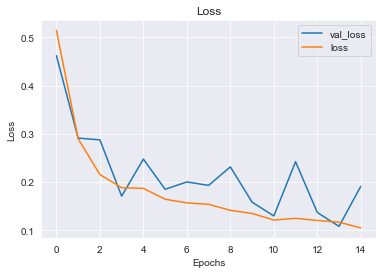

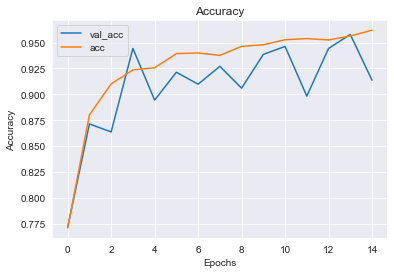

In [201]:
visualize_training_results(split_model_history)

### Evaluating split model
Splitting the training data into a training/validation mix led to the loss decreasing from 35.96% to 33.69% and accuracy increasing from 84.46% to 90.06%. The split dataset was trained multiple times using different augmentation values and that model that performed the best augmented the images least. Now that we have a somewhat tuned model we will import a transfer learning model and compare its results to the split model results.

In [202]:
print("Loss of the model is - " , split_model2.evaluate(test_split_generator)[0]*100, "%")
print("Accuracy of the model is - " , split_model2.evaluate(test_split_generator)[1]*100, "%")

20/20 [==============================] - 12s 548ms/step - loss: 0.3370 - acc: 0.9006
Loss of the model is -  33.69694650173187 %
20/20 [==============================] - 11s 516ms/step - loss: 0.3370 - acc: 0.9006
Accuracy of the model is -  90.06410241127014 %


In [ ]:
# Model History

#1 - ImageDataGenerator(rescale=1./255, rotation_range = 20, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                     #horizontal_flip=True, vertical_flip=True, validation_split=0.15)
    # Loss - 77.17% / Accuracy - 68.42%
    
#2 - ImageDataGenerator(rescale=1./255, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                      #horizontal_flip=True, vertical_flip=False, validation_split=0.15)
    # Loss - 30.05% / Accuracy - 88.62%
    
#3 - ImageDataGenerator(rescale=1./255, zoom_range=0.1, 
                                   #width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                                      #horizontal_flip=False, vertical_flip=False, validation_split=0.10)
    # Loss - 33.69% / Accuracy - 90.06%

## Modeling with Transfer Learning
Transfer learning is a machine learning method that uses the architecture and parameters of a previously trained model on a new dataset. Pretrained models can be very effective with smaller datasets like the one we're working with, especially in the context of predictive modeling problems that use image data as input. We will import the InceptionV3 pretrained model from Keras and add a new densely connected layer on top of the output. 

In [7]:
from keras.applications.inception_v3 import InceptionV3
based_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [8]:
for layer in based_model.layers:
    layer.trainable = False

In [18]:
x = layers.Flatten()(based_model.output)
x = layers.Dense(1024, kernel_regularizer=l2(0.001), activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, kernel_regularizer=l2(0.001), activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(based_model.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['acc'])

In [19]:
#model5.summary()

In [20]:
transfer_history = model.fit(train_split_dataset, validation_data=validation_split_dataset, epochs = 25)

Epoch 1/25
139/139 [==============================] - 246s 2s/step - loss: 5.9250 - acc: 0.7801 - val_loss: 2.1122 - val_acc: 0.8939
Epoch 2/25
139/139 [==============================] - 216s 2s/step - loss: 1.9562 - acc: 0.8478 - val_loss: 1.5047 - val_acc: 0.9092
Epoch 3/25
139/139 [==============================] - 229s 2s/step - loss: 1.4397 - acc: 0.8550 - val_loss: 1.1675 - val_acc: 0.9066
Epoch 4/25
139/139 [==============================] - 232s 2s/step - loss: 1.1652 - acc: 0.8599 - val_loss: 0.9545 - val_acc: 0.9143
Epoch 5/25
139/139 [==============================] - 241s 2s/step - loss: 0.9949 - acc: 0.8484 - val_loss: 0.8561 - val_acc: 0.8849
Epoch 6/25
139/139 [==============================] - 241s 2s/step - loss: 0.8733 - acc: 0.8570 - val_loss: 0.6879 - val_acc: 0.9169
Epoch 7/25
139/139 [==============================] - 231s 2s/step - loss: 0.7852 - acc: 0.8552 - val_loss: 0.7316 - val_acc: 0.8619
Epoch 8/25
139/139 [==============================] - 225s 2s/step - 

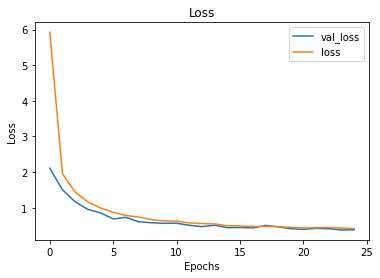

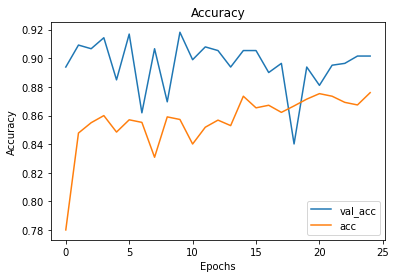

In [21]:
visualize_training_results(transfer_history)

### Evaluating transfer learning model

In [22]:
model_eval = model.evaluate(test_split_generator)

print('Model loss: {}'.format(model_eval[0]))
print('Model accuracy: {}'.format(model_eval[1]))

20/20 [==============================] - 21s 977ms/step - loss: 0.4964 - acc: 0.8285
Model loss: 0.49643319845199585
Model accuracy: 0.8285256624221802


In [ ]:
# Transfer Learning Model History

#1 - ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, validation_split=0.2)
        # Input 1 (150,150), Batch_size (32/32/32): Loss: 32.4% / Accuracy: 87%
        # Input 2 (256, 256), Batch_size (32/32/64): Loss: 35.6% / Accuracy: 86.4%

#2 - ImageDataGenerator(rescale=1./255, zoom_range=0.2, 
                                   #width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,
                                         #horizontal_flip=True, validation_split=0.2)
        # Input 1 (256,256), Batch_size (32,32,64): Loss: 41.1% / Accuracy: 86.2%
    
#3 - ImageDataGenerator(rescale=1./255, rotation_range=40, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, vertical_flip=True, validation_split=0.1)
        # Input 1 (256,256), Batch_size (32,32,32): Loss: 39.8% / Accuracy: 85.4%

#4 - ImageDataGenerator(rescale=1./255, zoom_range=0.2, 
                                   #width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
                                      #horizontal_flip=False, vertical_flip=False, validation_split=0.15)
        # Input - (150,150) Batch_size - NA / Loss: 29.75% / Accuracy: 88.94%
        
#5 - ImageDataGenerator(rescale=1./255, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, vertical_flip=False, validation_split=0.10)
        # Input - (150,150) Loss: 33.46% / Accuracy: 89.42%
        
#6 - ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, 
                                   #width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                         #horizontal_flip=True, vertical_flip=False, validation_split=0.20)
        # Input - (150,150) Loss: 40.30% / Accuracy: 86.38%
        


# Model Evaluation
Accuracy and loss are good metrics to gauge overall model performance and help to identify how to further tune the model for optimal performance. Once tuned, we will generate a confusion matrix and classification report to evaluate the specifics of our models predictive power.

In [214]:
#test_split_generator.reset()
Y_pred = split_model2.predict(test_split_generator)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]

print('Confusion Matrix')
print(confusion_matrix(test_split_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_split_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[185  49]
 [ 13 377]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.93      0.79      0.86       234
   PNEUMONIA       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

